# Visualization

### `! git clone https://github.com/ds3001f25/visualization.git`


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Communication and Visualization
- The previous lecture was about using plots and statistics to understand a variable (histograms, quantiles, boxplots, outliers, statistics)
- The lecture was somewhat mechanical: We're just knocking out plots and tables that are obviously useful for summarizing the data
- In this lecture, let's take a step back and think about what we're really doing
- If we do that, we can understand when our visualizations will be effective or not, and why
- I know we talked about some of these plots previously, but we're coming at the discussion from a different angle, so we'll reintroduce them as we go along

## Visualization is Powerful
- It's the early 2010's and Anne Case and Angus Deaton are doing research on mortality at Princeton
- Since most people don't die in a given year, deaths are actually pretty rare on average, so it's typically expressed as "$d$ per 100k people (per year)"
- They get the CDC WONDER data and analogous international sources, and plot mortality. They see this:

![All Cause Mortality](./src/all_cause_mortality.png)

- What is surprising here?


- Case and Deaton -- having determined that this is a real phenomenon and not a mistake -- dig into the mortality data by cause:

![Mortality by Cause](./src/mortality_by_cause.png)

- What is this? What have they discovered?


- The second plot is very clever: For example, Lung Cancer and Diabetes are included as counterpoints to the other causes, to show that some are declining some are flat, and they are dashed instead of solid to set off that distinction
- You cannot overstate the value of a well-constructed visualization

## Theory of Single Variable Visualization
- For either categorical or numeric variables, our goal is to accurately express information about the **frequency of different values**
- For categorical variables, the domain is composed of a finite number of responses, and the range is the count: It's a bar graph (a histplot with a categorical horizontal axis)
- For numeric variables, the domain is a range of real numeric values, and the range is the frequency/mass (histogram) or the density (kernel density plot)
- This is giving us an estimate of $f(x)$, the probability density/mass function of a random variable $X$

In [2]:
df = pd.read_csv('./data/pretrial_data.csv') # Load data
x = df['age'] # Age and Gini are nice numeric variables to play with
x = x[ x.isna()==False ].sample(50, random_state=10) # I only want 50 observations for today, not 23k
x= x.to_numpy() # Drop missings and convert x to numpy array; Pandas index is tedious

## Some stats about X:
sd = np.std(x) # standard deviation of x
N = len(x) # number of observations
med_x = np.median(x) # median of x
min_x = min(x) # min of x
max_x = max(x) # max of x

## Categorical Data
- The most common way to represent relative frequencies of categorical variables is the bar graph.

<Axes: xlabel='case_type', ylabel='Proportion'>

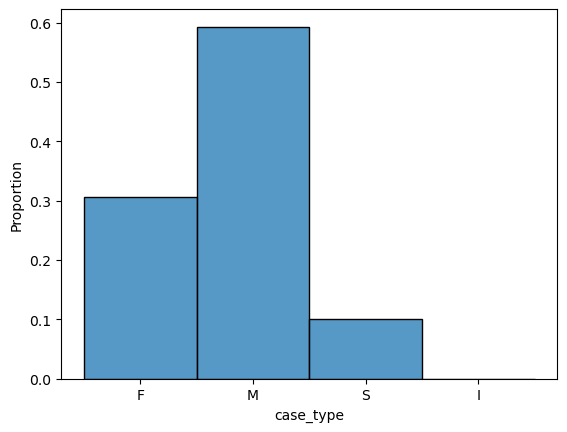

In [3]:
sns.histplot(data=df,x='case_type',stat='proportion') 

- Notice the option, `stat = 'proportion'` . This force the vertical axis into proportions or probabilities, rather than counts.

## Numeric Data
- Numeric data are significantly more difficult to handle than categorical data, since their values are difficult to faithfully represent visually
- We'll build our way up to the kernel density plot as a leading solution
- To start, what's the most primitive way to look at the data?
- Let's use a rugplot, and just mark the points on the horizontal axis:

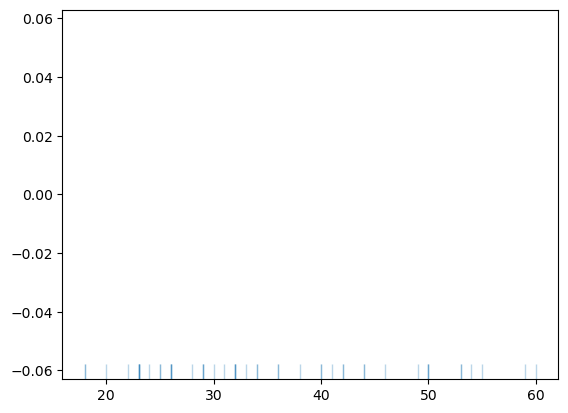

In [4]:
sns.rugplot(x,height=.04, alpha=.3)
plt.show()

- The rugplot is not very illuminating: We can see that the data take values roughly between 18 and 65, and the frequency seems to tail off after about 50
- The problem is: Common points overlap significantly, obscuring an accurate representation of the density $f(x)$. This is a common problem (e.g. scatterplots).
- Can we aggregate this information more effectively?

## Numeric Data
- We want a better representation of the frequency of occurrence for each value of $X$
- What we really want is some kind of estimate of $f(x)$: The density or mass function of $X$
- This motivates the idea of a histogram: Break the axis into bins, and plot by frequency: It's essentially a bargraph for small windows of values, and we're turning a numeric variable into a categorical one (this is also its big flaw)

<Axes: ylabel='Proportion'>

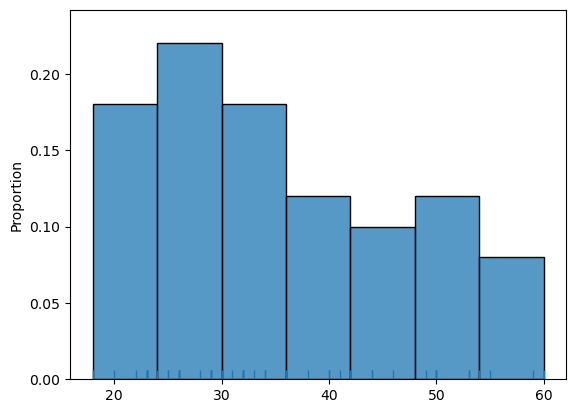

In [5]:
sns.rugplot(x)
sns.histplot(x,stat='proportion')

## The Histogram
- We like the histogram: Simple, effective, etc.
- The problem is, do we... believe it? As an estimator of $\hat{f}(x)$?
- Is there a principled way to pick the number of bins?
- Which one do you prefer:

<Axes: ylabel='Proportion'>

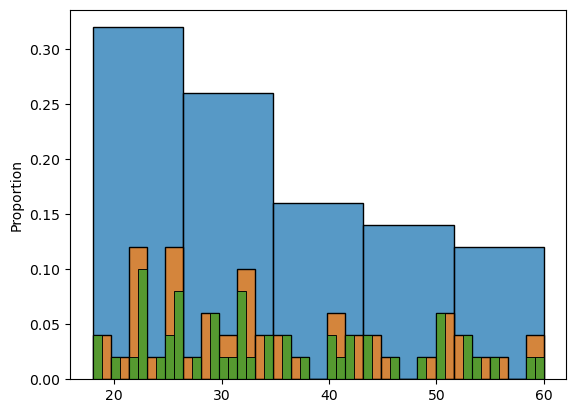

In [6]:
sns.histplot(x,bins=5,stat='proportion')
sns.histplot(x,bins=25,stat='proportion')
sns.histplot(x,bins=50,stat='proportion')

## Kernel Density Plots
- To avoid this issue of discrete bins, we have an alternative, superior tool
- The kernel density plot works slightly differently:
    - Instead of a point being a "spike" like the rug plot, associate a point with a function: Draw a little bell around it, for example. This is called a **kernel function**.
    - This smoothing reduces the jumpy behavior of the graph, and the unpredictability of how it behaves as we change the number of bins
    - This introduces bias, since we're smearing the data across the axis a bit, but reduces variance, since small changes in $X$ don't lead to huge changes in our plot
- We have a variable that allows us to tune how much smoothing there is, called the **bandwidth**, $h$


- The most popular kernel is the Normal of Gaussian kernel with bandwidth $h$,
$$
k(z) = \dfrac{1}{h\sqrt{2\pi}} e^{-(z/h)^2},
$$
- The next plot shows a normal kernel as the bandwidth goes down: It becomes more tightly concentrated around $0$ as $h$ gets smaller
- In this case, the bandwidth is like standard deviation of a Normally distributed random variable, but kernel density estimation is more general than that
- Important intuition: Small $h$/bandwidth means we're close to a rug plot, and large $h$/bandwidth means we're "smearing" the data more on the horizontal axis

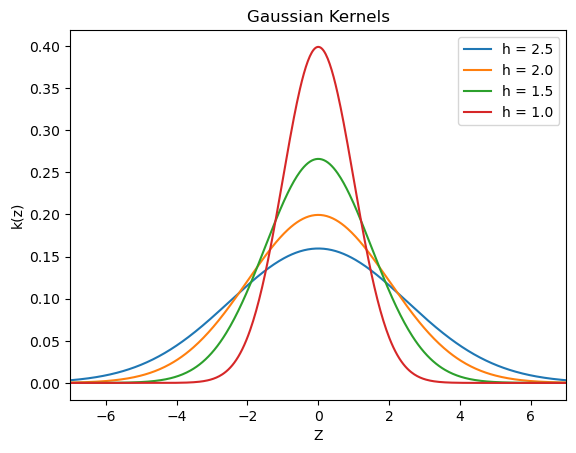

In [7]:
M = 500 # steps for grid
grid = np.linspace(-7,7,M) # Grid for plotting values

def normal_kernel(center,bandwidth):
    """ Normal kernel function. """
    density = np.exp( -(( (grid-center)/bandwidth)**2)/2 ) / (bandwidth * np.sqrt(2*np.pi))
    return density

## Compute normal kernels around 0 for various bandwidths:
y_10 = normal_kernel(0,1.0)
y_15 = normal_kernel(0,1.5)
y_20 = normal_kernel(0,2.0)
y_25 = normal_kernel(0,2.5)

## Plot kernel functions:
fig = sns.lineplot(x=grid,y=y_25, label='h = 2.5')
fig.set_xlim(-7, 7)
fig.set(title="Gaussian Kernels", xlabel='Z', ylabel='k(z)')
sns.lineplot(x=grid,y=y_20, label='h = 2.0')
sns.lineplot(x=grid,y=y_15, label='h = 1.5')
sns.lineplot(x=grid,y=y_10, label='h = 1.0')
plt.show()

## Kernels
- For each data point, we'll center one of these kernels at that value, as
$$
k(x) = \dfrac{1}{h \sqrt{2\pi}}e^{-( (x_i-x)/h)^2}
$$
- For the age variable from the justice data, let's plot each of these little bell curves/kernels
- What bandwidth should we pick? There is a rule-of-thumb or plug-in estimate that usually gives pretty good results, called **Silverman's Plug-in Estimate**:
$$
h_{s} = 1.06 \times \sigma \times N^{-1/5}
$$
    - $\sigma$: standard deviation
    - $N$: number of samples
- In practice, we might want to use a data-driven choice for $h$, and we'll cover that later in the course (cross validation)
- This shows you how each value in the rugplot gets its own bell curve/kernel function:

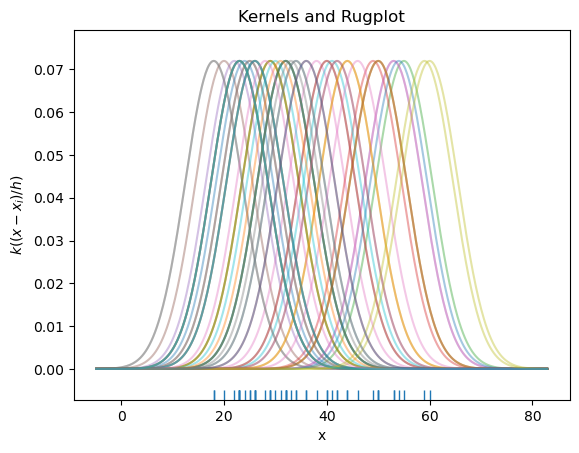

In [8]:
h = 1.06 * sd * N**(-1/5) # Silverman's plug-in bandwidth
h_s = h # save the plug-in value for later

M = 500 # steps for grid
grid = np.linspace(min_x-2*sd,max_x+2*sd,M) # X grid, +/2 standard deviations of median

kde = 0*grid
fig = sns.rugplot(x) # Start with a rugplot
fig.set(title="Kernels and Rugplot", xlabel='x', ylabel='$k( (x-x_i)/h )$')
for i in range( len(x) ): # For each data point...
    density = normal_kernel(x[i],h) # Compute the kernel function for this data point
    sns.lineplot(x=grid,y=density, alpha = .4) # Plot the kernel
    kde += density # Add this density to the overall KDE
kde = kde/N
plt.show()

## The Kernel Density Plot
- To get to the KDE plot, we simply average those bell curves:
$$
\hat{f}(x) = \dfrac{1}{N}\sum_{i=1}^N \dfrac{1}{h\sqrt{2\pi}} \exp \left\lbrace - \left(\dfrac{x-x_i}{h}\right)^2 \right\rbrace 
$$
- You'll see we get exactly the same result as Seaborn:

[Text(0.5, 1.0, 'Our Kernel Density Plot'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, '$\\hat{f}(x)$')]

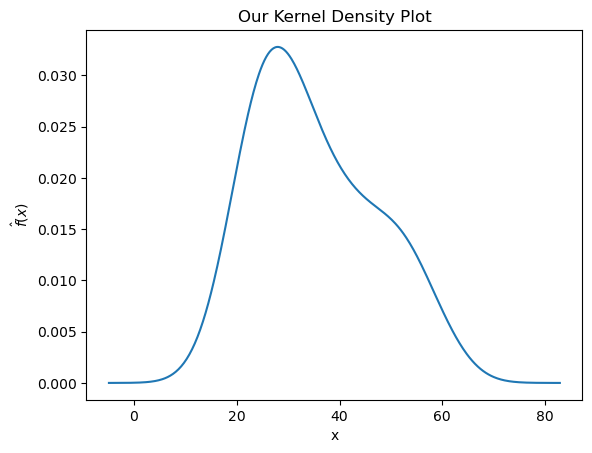

In [9]:
fig = sns.lineplot(x=grid,y=kde) # Our KDE estimator
fig.set(title="Our Kernel Density Plot", xlabel='x', ylabel='$\\hat{f}(x)$')

[Text(0.5, 1.0, "Seaborn's Kernel Density Plot"),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, '$\\hat{f}(x)$')]

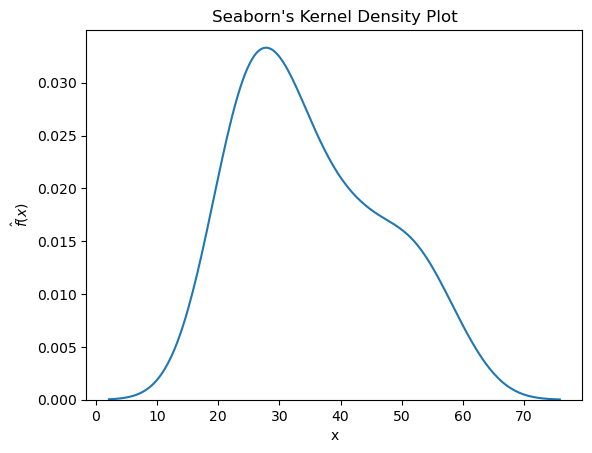

In [10]:
fig = sns.kdeplot(x) # Seaborn's KDE estimator
fig.set(title="Seaborn's Kernel Density Plot", xlabel='x', ylabel='$\\hat{f}(x)$')

## Why bother?
- So we've popped the hood on the kernel density plot, and seen that it's actually pretty easy to replicate Seaborn's output
- By doing this, we get a few things: 
    - We get the actual values of the KDE estimator, rather than just the picture: Maybe we want to use the KDE values somehow in a calculation
    - We can make different choices about the bandwidth $h$ and kernel function $k(z)$ --- The seaborn KDE plot only uses the Gaussian kernel
    - We get our own intuition about the tool that you will never get just by looking at APIs
    - We learn how kerneling/local smoothing works, which is a really powerful idea that we might use elsewhere (e.g. regression, $k$-nearest neighbor is a local smoother)
    - We can now start to think of the KDE as a statistical object: We can work out its statistical properties since we know the underlying equations

## Alternative Bandwidth
- Silverman's plug-in is based on a solid mathematical approximation, and is usually pretty good
- But we're not zombies, and sometimes it is not a good approximation: What if we want to play with the bandwidth?

Plug-in Bandwidth:  5.541666089858518
Our Bandwidth:  3


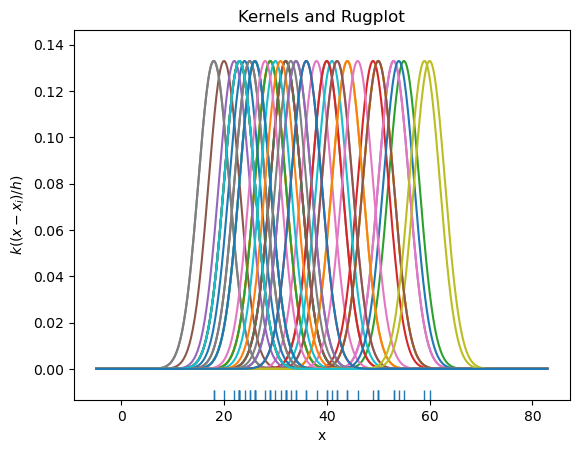

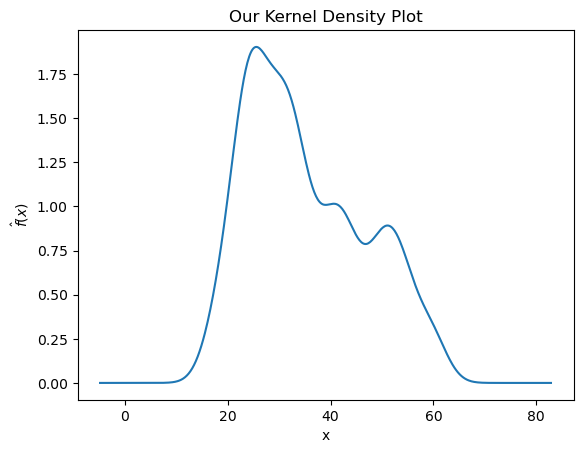

In [11]:
print('Plug-in Bandwidth: ', h_s)
h= 3 # Let's choose a different bandwidth
print('Our Bandwidth: ', h)
kde = 0*grid

## Rugplot and kde, same as earlier:
fig = sns.rugplot(x)
fig.set(title="Kernels and Rugplot", xlabel='x', ylabel='$ k((x-x_i)/h)$')
for i in range( len(x) ):
    density = normal_kernel(x[i],h)
    sns.lineplot(x=grid,y=density)
    kde += density
plt.show()
fig = sns.lineplot(x=grid,y=kde)
fig.set(title="Our Kernel Density Plot", xlabel='x', ylabel='$\\hat{f}(x)$')
plt.show()

Plug-in Bandwidth:  5.541666089858518


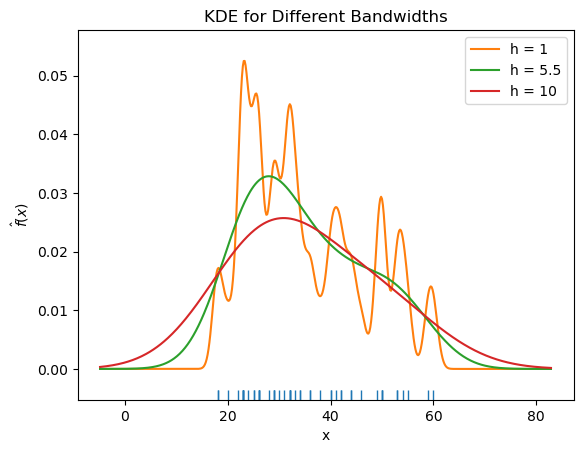

In [12]:
print('Plug-in Bandwidth: ', h_s)
H = [1, 5.5, 10] # Let's choose a different bandwidth

fig = sns.rugplot(x)
fig.set(title="KDE for Different Bandwidths", xlabel='x', ylabel='$ \\hat{f}(x)$')
for h in H: # For each alternative bandwidth...
    kde = 0*grid # New kernel density values
    for i in range( len(x) ): # For each value in the data... 
        density = normal_kernel(x[i],h) # Compute the kernel for this data point
        kde += density # Add to the kernel density
    kde = kde/N # Normalize the kernel density by 1/N
    sns.lineplot(x=grid,y=kde,label='h = ' + str(h)) # Add this series to the graph
plt.show() # Show the completed graph

## Overfitting and Underfitting
- We've already arrived at the central issue in machine learning
- Models often have hyperparameters like the bandwidth $h$ that give us degrees of freedom in tuning models: We learn about the underlying model and data by playing with it, but we typically don't have an obvious, uniquely best way to pick hyperparameters like $h$


- When we pick a very tight bandwidth, the kernel density plot seems to be overconfident about how much information it can extract from the limited data available: This is called **overfitting**
- When we pick a very wide bandwidth, the kernel density plot seems shapeless and timid about how much information it can extract from the data versus the model: This is called **underfitting**


- What's happening here is a **bias-variance trade-off**: 
    - We can pick a very tight bandwidth to reduce bias... but the lack of smoothing makes the predictions very high variance (the model overfits the data)
    - We can pick a very wide bandwidth to reduce variance... but this excess smoothing makes the bias large (the model underfits the data)
    - We'll cover the bias-variance trade-off in depth later in the course, but this is a first glimpse of the concept


- The job of machine learning is largely to develop methods by which to fit models to data in ways that avoid overfitting and underfitting, and deliver consistent and reliable predictions
- While plug-in methods are nice, there are data-driven tools to pick the bandwidth that we'll cover later in the course (least squares cross validation, likelihood cross validation)

## Alternative Kernel
- The general definition of a kernel density estimator is
$$
\hat{f}(x) = \dfrac{1}{N} \sum_{i=1}^N \dfrac{1}{h} k \left( \dfrac{x-x_i}{h} \right)
$$
where an arbitrary $k(z)$ replaces the Normal density function


- Why? A few reasons:
    - In some settings, like when $X$ is time, it's unrealistic to smooth symmetrically near 0, since you'll get negative values for time
    - The bandwidth might be more interpretable or easily estimated
    - There is actually a known optimal kernel function, called the Epanechnikov kernel, and we might want to use it
    - If you know that there are spots where the data vanish, an alternative kernel won't oversmooth like the Gaussian and suggest there are data there


- Instead of the Normal kernel,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2}
$$
let's use the uniform kernel,
$$
k(z) = \begin{cases}
1/2, & |z| \le 1\\
0, & \text{otherwise}
\end{cases}
$$
- This gives us something closer to a classic histogram, since we're using the "bump function" as a kernel instead of a bell curve


- Our new kernel density estimator is
$$
\hat{f}(x) = \dfrac{1}{N} \sum_{i=1}^N \mathbb{I} \left\lbrace \left| \dfrac{x-x_i}{h} \right| \le 1 \right\rbrace \times \dfrac{1}{2h}
$$
where the indicator function $\mathbb{I} \{A\}$ is 1 if $A$ is true, and zero otherwise.

[Text(0.5, 1.0, 'The Bump Function'),
 Text(0.5, 0, 'z'),
 Text(0, 0.5, '$ k(z)$')]

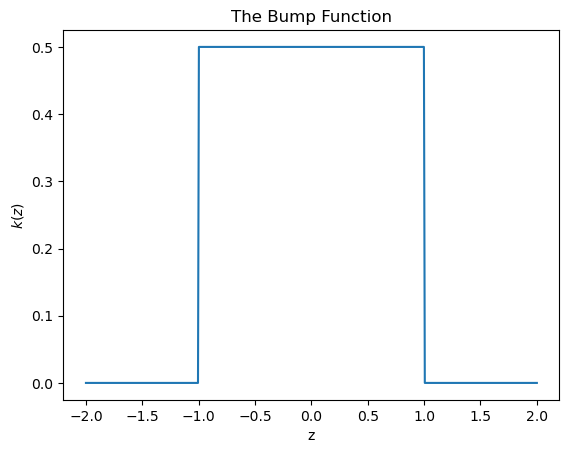

In [13]:
gr = np.linspace(-2,2,M)
kr = (np.abs(gr) <= 1) * .5
fig = sns.lineplot(x=gr,y=kr) # Bump function
fig.set(title="The Bump Function", xlabel='z', ylabel='$ k(z)$')

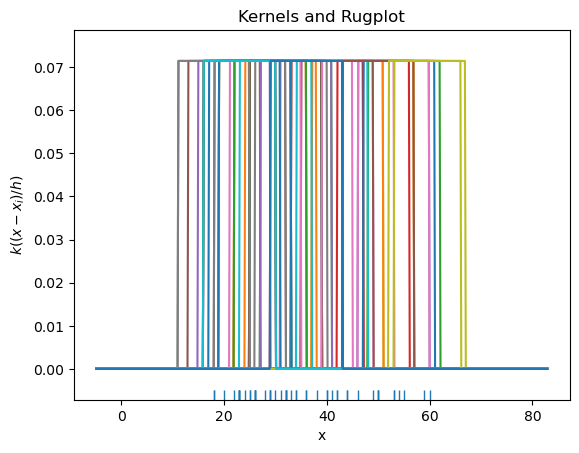

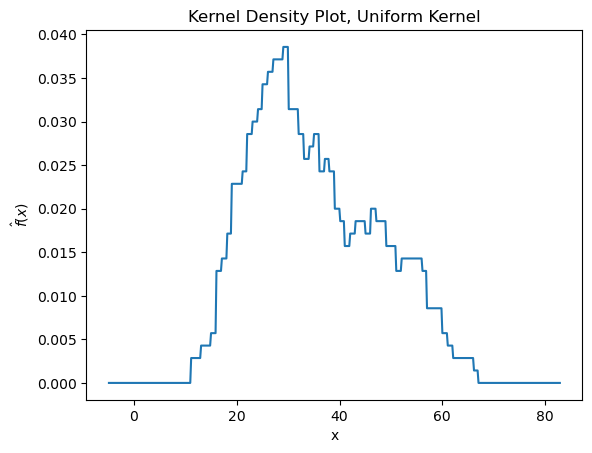

In [14]:
h = 7 # bandwidth

def uniform_kernel(center,bandwidth):
    """ Uniform kernel function. """
    density = ( np.abs( (grid-center)/bandwidth )<=1 )*(.5/h)
    return density

fig = sns.rugplot(x)
fig.set(title="Kernels and Rugplot", xlabel='x', ylabel='$ k((x-x_i)/h)$')
kde = 0*grid
for i in range( len(x) ):
    density = uniform_kernel(x[i],h)
    sns.lineplot(x=grid,y=density)
    kde += density
plt.show()

kde=kde/N # Normalize the sum of kernels
fig = sns.lineplot(x=grid,y=kde)
fig.set(title="Kernel Density Plot, Uniform Kernel", xlabel='x', ylabel='$ \\hat{f}(x)$')
plt.show()

<Axes: ylabel='Count'>

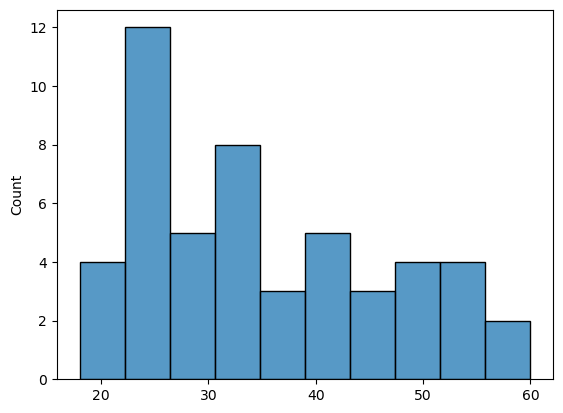

In [15]:
sns.histplot(x,bins=10) # How can you go back to this?

## You're Free
- You don't need canned software: You understand kernel density estimation on a fundamental level, and can write your own code to implement it
- Is canned software nice? Of course, but you understand a kernel density plot from the ground up.
- If you ever want to use this approach to smoothing, you have the ability to pull code and equations, and fashion them into the solution you actually want, instead of settling for what existing solutions can do.
- More importantly, you are aware of the choices being made and the consequences.

## Bi-Variate Visualizations
- Representing a single numeric or categorical variable was mostly about the appropriate way to plot frequencies: A bar graph or kernel density plot for the density/mass function $f(x)$
- When we move to two variables, we have a joint density/mass function, $f(x,y)$, that tries to express the relative frequency of each pair $(x,y)$
- We also intuitively want to think about the expected value of $Y$ conditional on $X$, $\mathbb{E}[Y|X=x]$, but we'll come back to that later as we introduce analytics tools

## Theory of Bi-Variate Visualization
- Let's think about the kind of variable in the **domain** (the x-axis) and the **range** (the y-axis): Each can be numeric or categorical
- For each pair of possibilities, what's the appropriate plot?

|  | Categorical $Y$ | Numeric $Y$ |
| :------: |  :------: | :------: |
| Categorical $X$ | Bubble Plot (`.scatterplot`), Stacked Bar Plot (`.histplot`) | Violin Plot (`.violin`); maybe Strip/Swarm Plot (`.stripplot`, `.swarmplot`), |
| Numeric $X$ | Stacked Kernel  (`.kdeplot`) | Scatter Plot (`.scatterplot`), Joint plot (`.jointplot`) |

- These plots are intended to reveal information about the joint density $f(x,y)$: What is the relationship between $X$ and $Y$ in the data?
- Good plots will suggest a relationship between $X$ and $Y$: As $X$ varies, how does the density/mass of $Y$ appear to change? This will lead us to something called a conditional expectation function, $\hat{y}(x) = \mathbb{E}[Y|X=x]$

## Categorical $X$, Categorical $Y$
- We're trying to exhibit the joint frequency of two categorical variables
- Hapless students often use a scatterplot, turning in something with a bunch of dots that only indicates that pair of values co-occurred at least once -- That is not a very useful plot. It just indicates that pair occurs in the data, but not the frequency of that pair.
- Instead, how can we represent the joint density more accurately?
    1. Bubble plot: Each dot represents an $(X,Y)$ pair that occurs in the data, but the size of the dot is scaled to frequency
    2. Stacked Bar Graph: The categorical $X$ is on the horizontal axis, and the vertical axis is proportion, but the bar for each $X$ is chopped up in proportion to $Y$

In [16]:
gdf = (df.loc[:,['case_type','bond_type'] ]).groupby(['case_type','bond_type']).size() # Compute frequencies of case/bond-type pairs

rdf = gdf.to_frame(name = 'size').reset_index() # Fix formatting issues so it becomes a dataframe we can easily plot
rdf.head()

,case_type,bond_type,size
0,F,1,3898
1,F,2,1837
2,F,3,1138
3,F,4,21
4,F,5,37


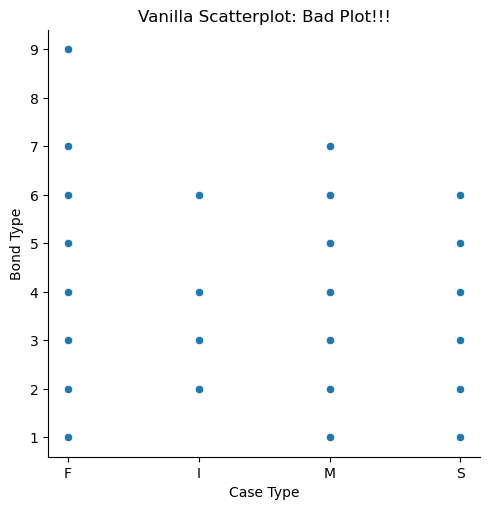

In [17]:
# The dots are all the same size...
fig = sns.relplot(data = rdf, x='case_type',y='bond_type') 
fig.set(title="Vanilla Scatterplot: Bad Plot!!!", xlabel='Case Type', ylabel='Bond Type')


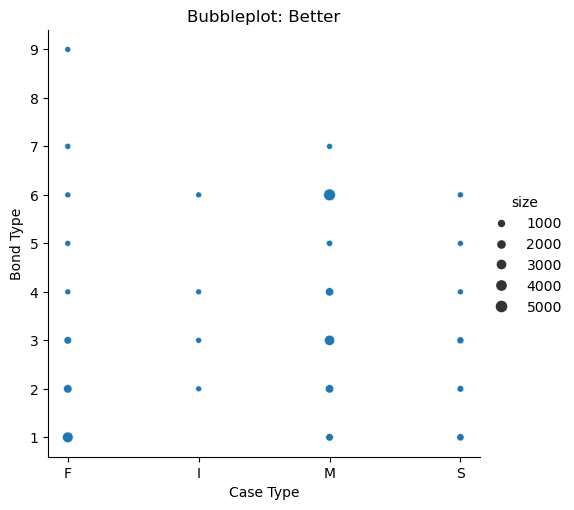

In [18]:
# Use the size variable to set the bubbles
fig = sns.relplot(data = rdf, x='case_type',y='bond_type',size='size') 
fig.set(title="Bubbleplot: Better", xlabel='Case Type', ylabel='Bond Type')

[Text(0.5, 1.0, 'Bubbleplot'),
 Text(0.5, 0, 'Case Type'),
 Text(0, 0.5, 'Bond Type')]

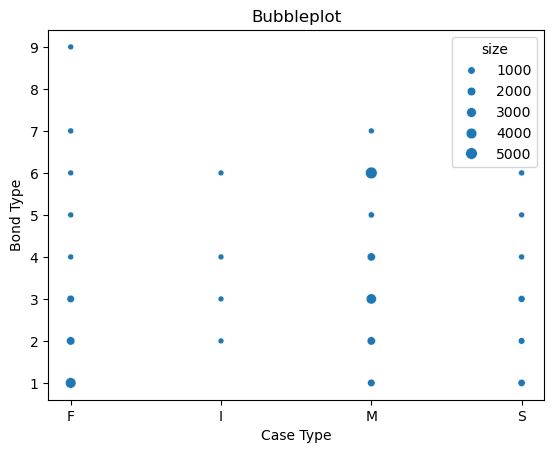

In [19]:
# Scatterplot and relplot give the same output
fig = sns.scatterplot(data = rdf, x='case_type',y='bond_type',size='size')
fig.set(title="Bubbleplot", xlabel='Case Type', ylabel='Bond Type')

[Text(0.5, 1.0, 'Stacked Histogram'), Text(0.5, 0, 'Case Type')]

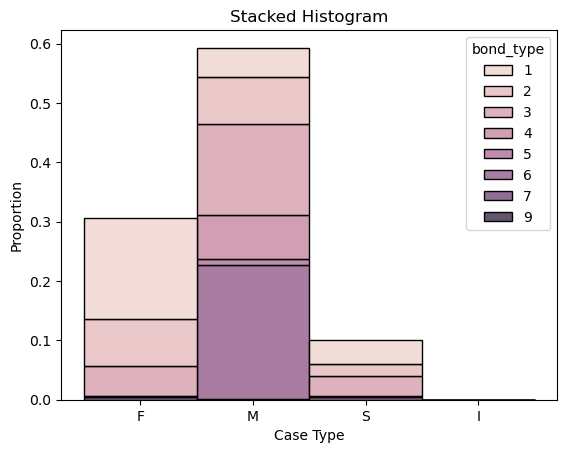

In [20]:
# Stacked histogram plot
fig = sns.histplot(data = df, x='case_type',hue='bond_type',stat='proportion',multiple='stack')
fig.set(title="Stacked Histogram", xlabel='Case Type')

[Text(0.5, 1.0, 'Stacked Histogram'), Text(0.5, 0, 'Bond Type')]

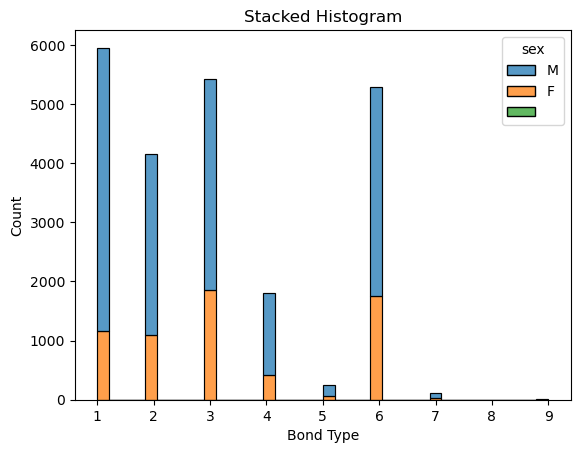

In [21]:
fig = sns.histplot(data = df, x='bond_type',hue='sex',multiple='stack')
fig.set(title="Stacked Histogram", xlabel='Bond Type')

## Numeric $X$, Numeric $Y$
- The humble, reliable scatterplot
- However, scatterplots can be very misleading about $f(x,y)$, as we'll see
- You can instead use a 2D histogram or a jointplot, when it's more appropriate

[Text(0.5, 1.0, 'Scatterplot'),
 Text(0.5, 0, 'Bond (IHS)'),
 Text(0, 0.5, 'Sentence (IHS) ')]

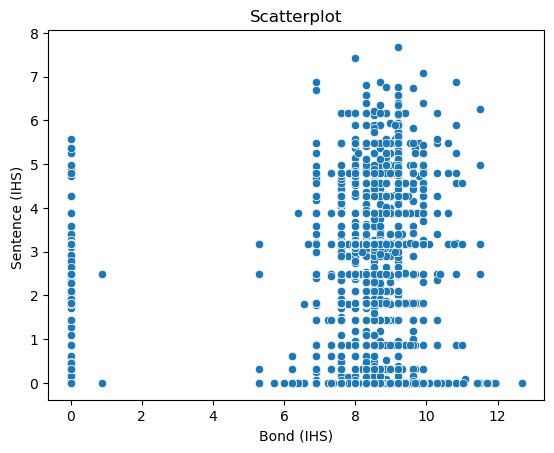

In [22]:
fig = sns.scatterplot(y=np.arcsinh(df['sentence']), x=np.arcsinh(df['bond']) )
fig.set(title="Scatterplot", xlabel='Bond (IHS)', ylabel='Sentence (IHS) ')

[Text(0.5, 1.0, '2D Histplot'),
 Text(0.5, 0, 'Bond (IHS)'),
 Text(0, 0.5, 'Sentence (IHS) ')]

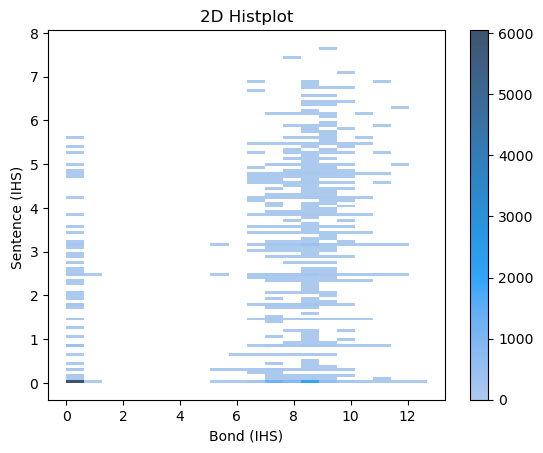

In [23]:
# When both x and y are assigned, a bivariate histogram is computed and shown as a heatmap
fig = sns.histplot(y=np.arcsinh(df['sentence']), x=np.arcsinh(df['bond']),  cbar=True)
fig.set(title="2D Histplot", xlabel='Bond (IHS)', ylabel='Sentence (IHS) ')

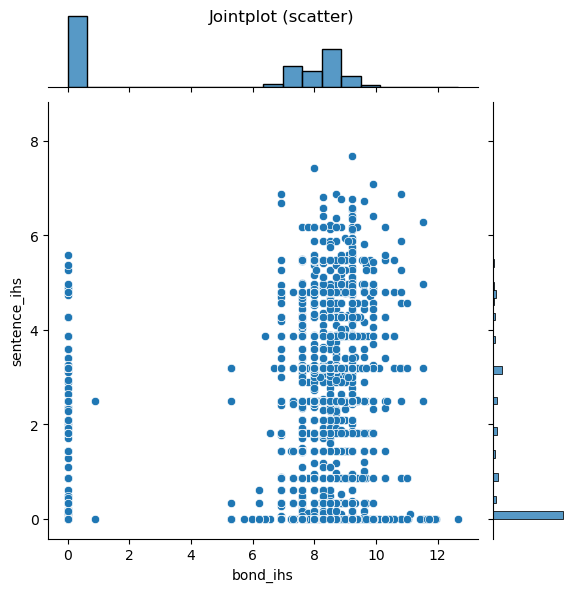

In [24]:
df['sentence_ihs'] = np.arcsinh(df['sentence'])
df['bond_ihs'] = np.arcsinh(df['bond'])

# Create a scatterplot with marginal histograms
fig = sns.jointplot(data=df, y='sentence_ihs',x='bond_ihs')
fig.fig.suptitle("Jointplot (scatter)")
plt.show()


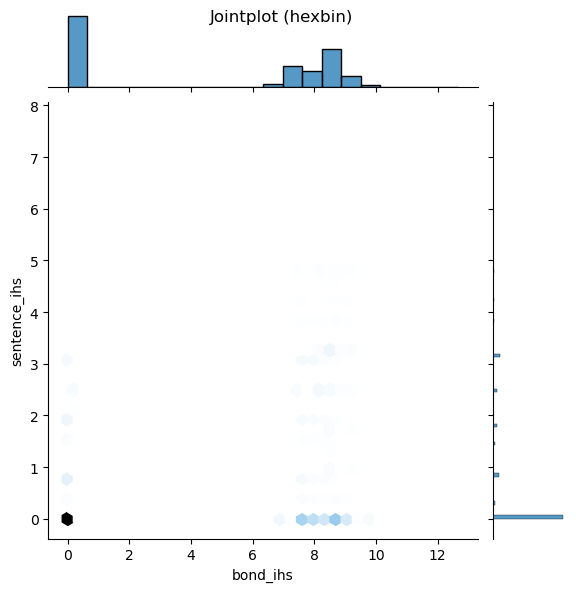

In [25]:
# A bivariate histogram using hexagonal bins
fig = sns.jointplot(data=df, y='sentence_ihs',x='bond_ihs',kind='hex')
fig.fig.suptitle("Jointplot (hexbin)")
plt.show()

/Users/eqc3xa/Dev/miniforge/envs/ds3001/lib/python3.10/site-packages/seaborn/axisgrid.py:1889: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


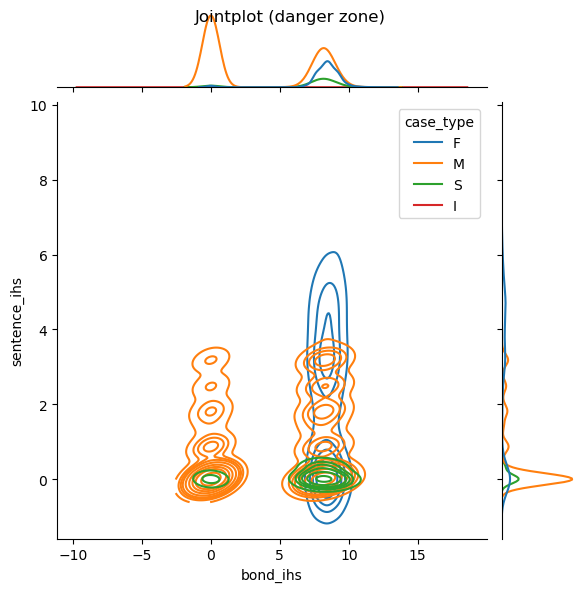

In [26]:
# Draw both bivariate and univariate KDEs
fig = sns.jointplot(data=df, y='sentence_ihs',x='bond_ihs',kind='kde', hue='case_type')
fig.fig.suptitle("Jointplot (danger zone)")
plt.show()

- The scatterplot: Great, but potentially very misleading
- In some ways, the scatterplot is like a 2D rugplot, and the jointplot/hexbin is like a 2D histogram (plus the marginal histograms)

## Categorical $X$, Numeric $Y$
- In this case, we have discrete values on the horizontal axis, and numeric ones on the vertical access
- There are three solutions, two of which are bad (strip plot, swarm plot) and one of which is fine (violin plot)


- The strip plot uses a scatter-like strategy to represent $Y$, associating clouds of points with discrete values on the horizontal axis.

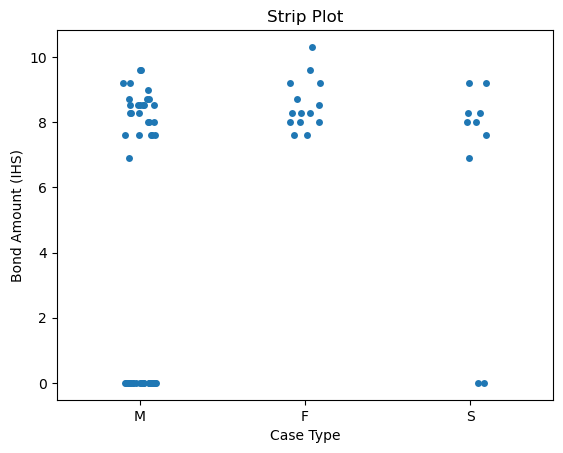

In [27]:
df['sentence_ihs'] = np.arcsinh(df['sentence'])
df['bond_ihs'] = np.arcsinh(df['bond'])

# Draw a categorical scatterplot using jitter to reduce overplotting.
fig = sns.stripplot(data=df.sample(100,random_state=100),x='case_type',y='bond_ihs')
fig.set(title="Strip Plot", xlabel='Case Type', ylabel='Bond Amount (IHS)')
plt.show()


- The swarm plot tries to arrange these points in a more strategic way, so that the relative frequencies are more obvious.

/Users/eqc3xa/Dev/miniforge/envs/ds3001/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


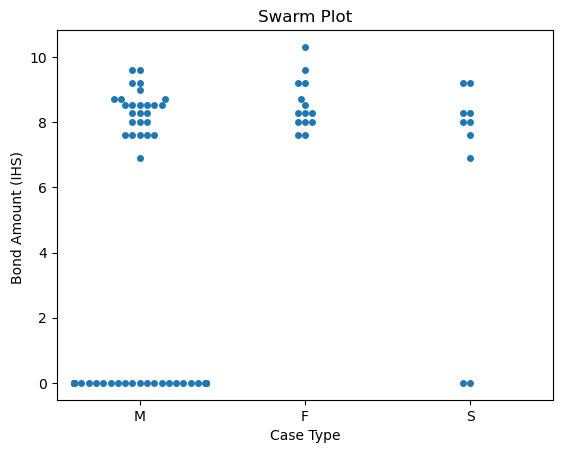

In [28]:
# Draw a categorical scatterplot with points adjusted to be non-overlapping.
fig = sns.swarmplot(data=df.sample(100,random_state=100),x='case_type',y='bond_ihs')
fig.set(title="Swarm Plot", xlabel='Case Type', ylabel='Bond Amount (IHS) ')
plt.show()

- This is not going to work if the data are sufficiently large: There will be too many dots overlapping and competing for space
- This motivates using, basically, kernel density plots along the $Y$ axis for each category on the $X$ axis
- This is called a **violin plot**, and throws in a boxplot for free:

[Text(0.5, 1.0, 'Violin Plot (vanilla)'),
 Text(0.5, 0, 'Case Type'),
 Text(0, 0.5, 'Bond Amount (IHS)')]

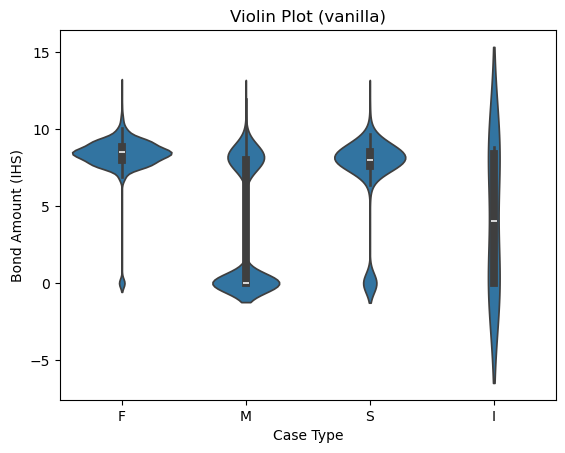

In [29]:
# Draw a patch representing a KDE and add observations or box plot statistics.
fig = sns.violinplot(data=df, x='case_type', y='bond_ihs')
fig.set(title="Violin Plot (vanilla)", xlabel='Case Type', ylabel='Bond Amount (IHS)')

[Text(0.5, 1.0, 'Violin Plot (I like this better)'),
 Text(0.5, 0, 'Case Type'),
 Text(0, 0.5, 'Bond Amount (IHS)')]

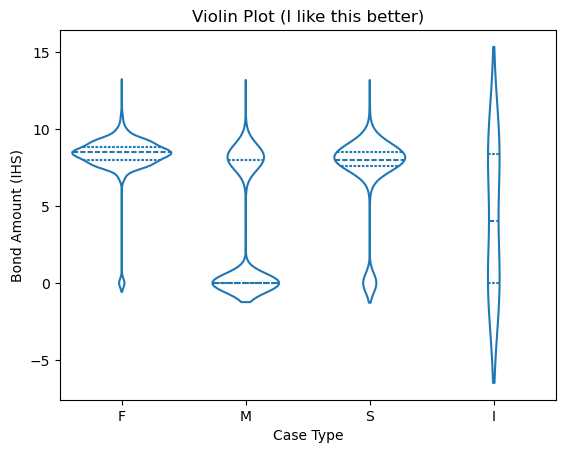

In [30]:
# Only show the data quarties
fig = sns.violinplot(data=df, x='case_type', y='bond_ihs' , inner='quart',fill=False)
fig.set(title="Violin Plot (I like this better)", xlabel='Case Type', ylabel='Bond Amount (IHS)')

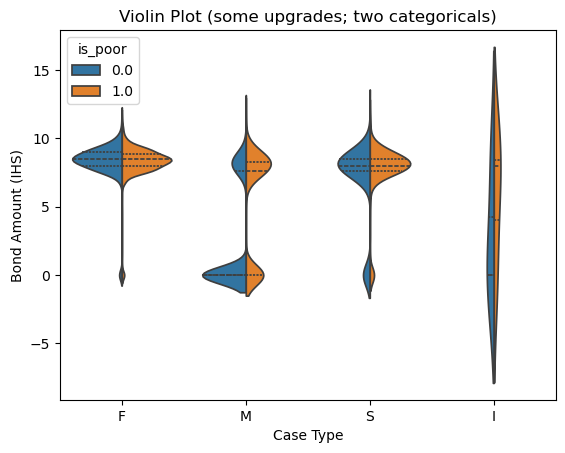

In [31]:
# Draw “split” violins to take up less space
fig = sns.violinplot(data=df, x='case_type', y='bond_ihs', hue='is_poor', split=True, inner='quart' )
fig.set(title="Violin Plot (some upgrades; two categoricals)", xlabel='Case Type', ylabel='Bond Amount (IHS)')
plt.show()


[Text(0.5, 1.0, 'Violin Plot (some upgrades; two categoricals)'),
 Text(0.5, 0, 'Case Type'),
 Text(0, 0.5, 'Bond Amount (IHS)')]

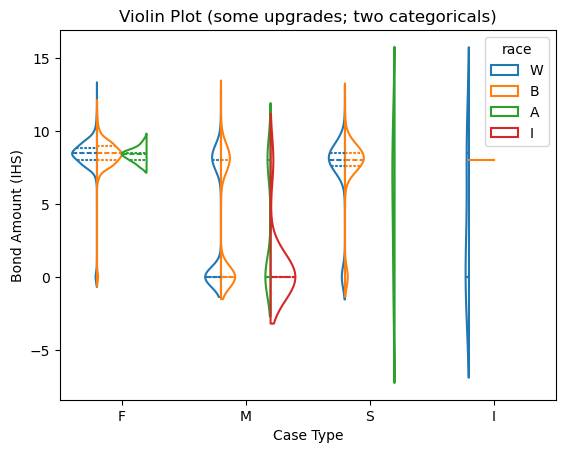

In [32]:
fig = sns.violinplot(data=df, x='case_type', y='bond_ihs', hue='race', split=True, fill = False, inner='quart' )
fig.set(title="Violin Plot (some upgrades; two categoricals)", xlabel='Case Type', ylabel='Bond Amount (IHS)')

- Without the fill, they become kind of ugly, but I think they're easier to read.

[Text(0.5, 1.0, 'Violin Plot (some upgrades; two categoricals)'),
 Text(0.5, 0, 'Case Type'),
 Text(0, 0.5, 'Bond Amount (IHS)')]

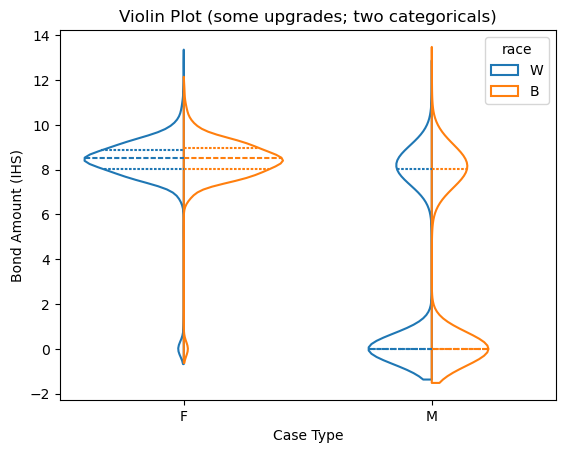

In [33]:
# Simplification: choose categories of interest
filter = (df['case_type'].isin(['F','M'])) * (df['race'].isin(['B','W']))
gdf = df[filter]
fig = sns.violinplot(data=gdf, x='case_type', y='bond_ihs', hue='race', split=True, fill = False, inner='quart' )
fig.set(title="Violin Plot (some upgrades; two categoricals)", xlabel='Case Type', ylabel='Bond Amount (IHS)')

## Numeric $X$, Categorical $Y$
- Ah, a hard one. We have a numeric or continuous variable on the horizontal axis, and a categorical or discrete one on the vertical.
- So as we roll the $X$ value from left to right, we want to see how the proportions of the categories vary.
- You can make this graph, I am not sure it has a canonical name, so I will call it a "Stacked Kernel Plot"

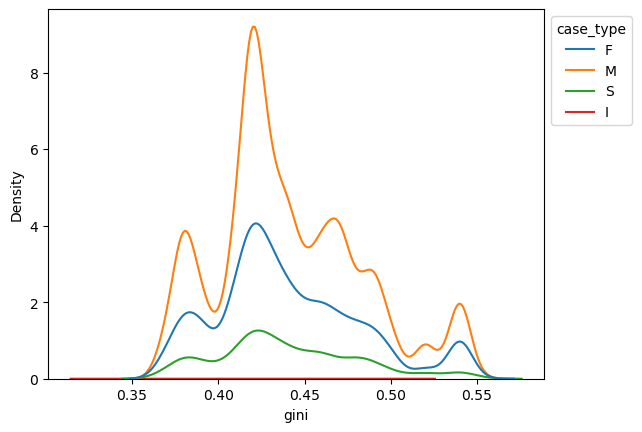

In [34]:
# Plot conditional distributions with hue mapping of a second variable:
ax = sns.kdeplot(x=df['gini'], hue= df['case_type'])
ax = sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

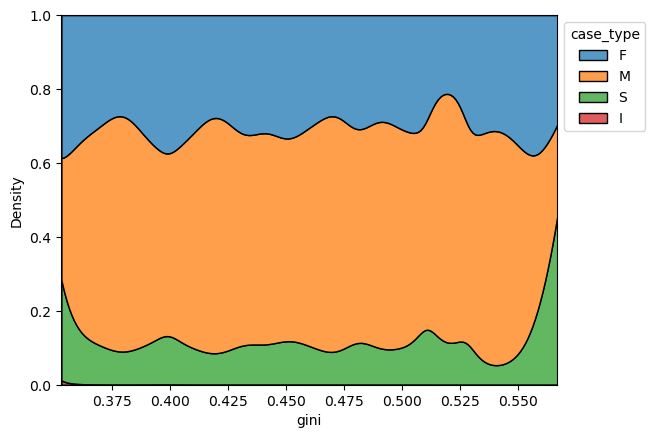

In [35]:
# Normalize the stacked distribution at each value in the grid
ax = sns.kdeplot(x=df['gini'], hue= df['case_type'], multiple='fill')
ax = sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#fig.set(title="Stacked Kernel Plot", xlabel='Gini', ylabel='Case Type ')

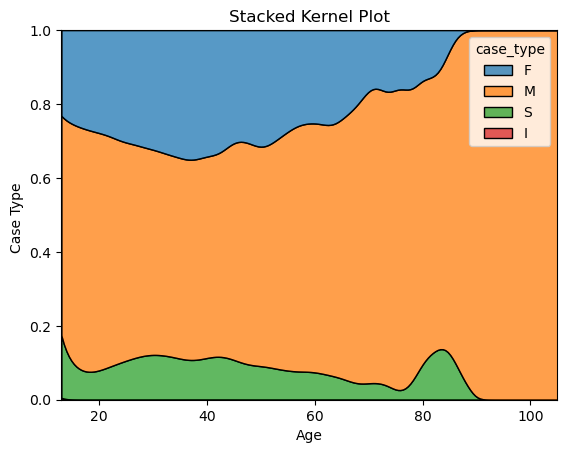

In [36]:
fig = sns.kdeplot(x=df['age'], hue= df['case_type'], multiple='fill')
fig.set(title="Stacked Kernel Plot", xlabel='Age', ylabel='Case Type ')
plt.show()

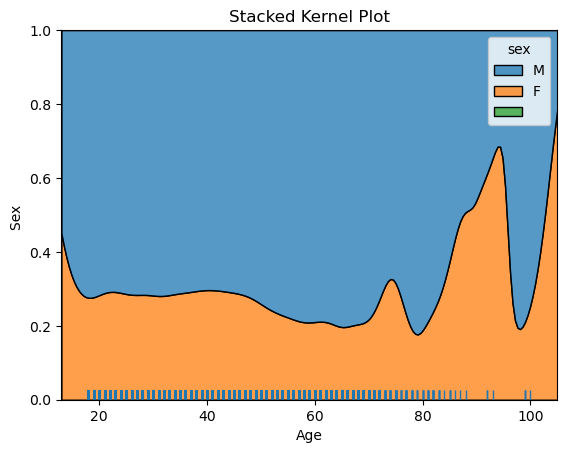

In [37]:
fig = sns.rugplot(x=df['age'])
sns.kdeplot(x=df['age'], hue= df['sex'], multiple='fill')
fig.set(title="Stacked Kernel Plot", xlabel='Age', ylabel='Sex ')
plt.show()

/var/folders/rh/pvlybnnx6h96n6b57j1x48gr0000gp/T/ipykernel_39107/2851449302.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fig = sns.kdeplot(x=np.arcsinh(df['sentence']), hue= df['case_type'], multiple='fill')


[Text(0.5, 1.0, 'Stacked Kernel Plot'),
 Text(0.5, 0, 'Sentence (IHS)'),
 Text(0, 0.5, 'Case Type ')]

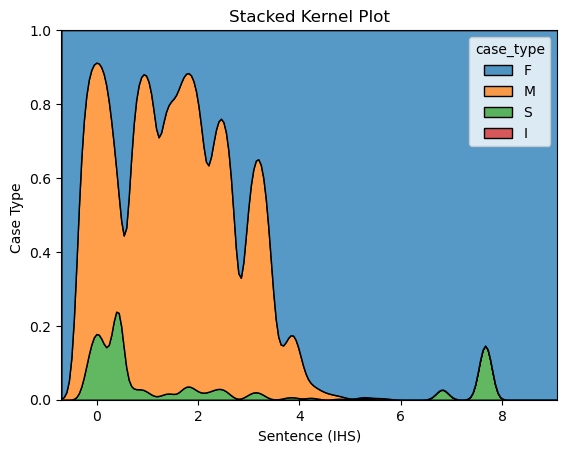

In [38]:
fig = sns.kdeplot(x=np.arcsinh(df['sentence']), hue= df['case_type'], multiple='fill')
fig.set(title="Stacked Kernel Plot", xlabel='Sentence (IHS)', ylabel='Case Type ')

## Bi-Variate Visualization
|  | Categorical $Y$ | Numeric $Y$ |
| :------: |  :------: | :------: |
| Categorical $X$ | Bubble Plot (`.scatterplot`), Stacked Bar Plot (`.histplot`) | Violin Plot (`.violin`); maybe Strip/Swarm Plot (`.stripplot`, `.swarmplot`), |
| Numeric $X$ | Stacked Kernel  (`.kdeplot`) | Scatter Plot (`.scatterplot`), Joint plot (`.jointplot`) |


## Higher Dimensional Plots
- We have a serious issue once we go beyond two dimensions. If we have two choices -- numeric and categorical -- those choices branch exponentially: For $2^1$ there are the bar chart and histogram/kernel density, and for $2^2=4$ there are the bubble/scatter/grouped kernel plots, but for $2^3 = 8$ we just have too many scenarios to think about
- By using `hue` and `shape` you can squeeze four dimensions out of a scatterplot, for example, but it will potentially become hard to interpret
- Remember: Your goal is really to provide clear information about the joint density

## Conclusion
- Visualizations are non-parametric estimators: They provide a way of understanding the data with recourse to parameterized models (e.g. linear regression)
- Visualizations can be quantitatively very sophisticated
- The problem is that when we have lots of variables (>4, not to mention millions), our ability to visualize in high dimensions breaks down: We are simple creatures
- This motivates a move from using **visualization** to summarize and explore data to **models/algorithms** that can accommodate high-dimensional data
- Even though our focus moving forward will be more on models/algorithms, visualization is still one of our most powerful tools for understanding data